# pPXF: Bootstrapping non-parametric stellar population

Usage example for the procedure pPXF originally described in [Cappellari & Emsellem (2004)](http://adsabs.harvard.edu/abs/2004PASP..116..138C), substantially upgraded in [Cappellari (2017)](http://adsabs.harvard.edu/abs/2017MNRAS.466..798C) and with the inclusion of photometry and linear constraints in [Cappellari (2023)](https://ui.adsabs.harvard.edu/abs/2023MNRAS.526.3273C).

* V1.0.0: Michele Cappellari, Oxford, 29 March 2022
* V1.1.0: MC, Oxford, 28 November 2023: Updated for pPXF 9.0 using the new `sps_util`.
* V1.1.1: MC, Oxford, 7 February 2024: Updated for pPXF 9.1 using the improved `sps_util.mass_to_light`.

![pPXF](https://www-astro.physics.ox.ac.uk/~cappellari/software/ppxf_logo.svg)

In [1]:
from time import perf_counter as clock
from pathlib import Path
from urllib import request

import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

from ppxf.ppxf import ppxf
import ppxf.ppxf_util as util
import ppxf.sps_util as lib

## Function to boostrap the spectrum residuals

In [2]:
def bootstrap_residuals(model, resid, wild=True):
    """
    https://en.wikipedia.org/wiki/Bootstrapping_(statistics)#Resampling_residuals
    https://en.wikipedia.org/wiki/Bootstrapping_(statistics)#Wild_bootstrap

    Davidson & Flachaire (2008) eq.(12) gives the recommended form
    of the wild bootstrapping probability used here.

    https://doi.org/10.1016/j.jeconom.2008.08.003

    :param spec: model (e.g. best fitting spectrum)
    :param res: residuals (best_fit - observed)
    :param wild: use wild bootstrap to allow for variable errors
    :return: new model with bootstrapped residuals

    """
    if wild:    # Wild Bootstrapping: generates -resid or resid with prob=1/2
        eps = resid*(2*np.random.randint(2, size=resid.size) - 1)
    else:       # Standard Bootstrapping: random selection with repetition
        eps = np.random.choice(resid, size=resid.size)

    return model + eps

## Read the spectrum

Read SDSS DR8 galaxy spectrum taken from here http://www.sdss3.org/dr8/
The spectrum is *already* log rebinned by the SDSS DR8 pipeline and `ppxf_util.log_rebin` should not be used in this case.

In [3]:
file_name = Path(lib.__file__).parent / 'spectra' / 'NGC3522_SDSS_DR8.fits'
hdu = fits.open(file_name)
t = hdu[1].data

In [4]:
redshift = float(hdu[1].header["Z"])               # SDSS redshift estimate
galaxy = t['flux']/np.median(t['flux'])     # Normalize spectrum to avoid numerical issues
wave = t['wavelength']

The SDSS wavelengths are in vacuum, while the MILES ones are in air. For a rigorous treatment, the SDSS vacuum wavelengths should be converted into air wavelengths and the spectra should be resampled. To avoid resampling, given that the wavelength dependence of the correction is very weak, I approximate it with a constant factor.


In [5]:
wave *= np.median(util.vac_to_air(wave)/wave)

I choose the noise to give $\chi^2/{\rm DOF}=1$ without regularization (`regul=0`).
A constant noise is not a bad approximation in the fitted wavelength range and reduces the noise in the fit.


In [6]:
noise = np.full_like(galaxy, 0.01635)  # Assume constant noise per pixel here

The velocity step per spectral pixel was already chosen by the SDSS pipeline and I convert it below to km/s.


In [7]:
c = 299792.458                          # speed of light in km/s
d_ln_lam = np.log(wave[-1]/wave[0])/(wave.size - 1)  # Average ln_lam step
velscale = c*d_ln_lam                   # eq. (8) of Cappellari (2017)
FWHM_gal = 2.76                         # SDSS has an approximate instrumental resolution FWHM of 2.76A.

## Setup the stellar templates

pPXF can be used with any set of SPS population templates. However, I am currently providing (with permission) ready-to-use template files for three SPS. One can just uncomment one of the three models below. The included files are only a subset of the SPS that can be produced with the models, and one should use the relevant software to produce different sets of SPS templates if needed.

1. If you use the [fsps v3.2](https://github.com/cconroy20/fsps) SPS model templates, please also cite [Conroy et al. (2009)](https://ui.adsabs.harvard.edu/abs/2009ApJ...699..486C) and [Conroy et al. (2010)](https://ui.adsabs.harvard.edu/abs/2010ApJ...712..833C) in your paper.

2. If you use the [GALAXEV v2000](http://www.bruzual.org/bc03/) SPS model templates, please also cite [Bruzual & Charlot (2003)](https://ui.adsabs.harvard.edu/abs/2003MNRAS.344.1000B) in your paper.

3. If you use the [E-MILES](http://miles.iac.es/) SPS model templates, please also cite [Vazdekis et al. (2016)](https://ui.adsabs.harvard.edu/abs/2016MNRAS.463.3409V) in your paper. 
<font color='red'>WARNING: the E-MILES models do not include very young SPS and should not be used for highly star forming galaxies.</font>  

In [8]:
# sps_name = 'fsps'
# sps_name = 'galaxev'
sps_name = 'emiles'

Read SPS models file from my GitHub if not already in the pPXF package dir. I am not distributing the templates with pPXF anymore.
The SPS model files are also available [this GitHub page](https://github.com/micappe/ppxf_data).

In [9]:
ppxf_dir = Path(lib.__file__).parent
basename = f"spectra_{sps_name}_9.0.npz"
filename = ppxf_dir / 'sps_models' / basename
if not filename.is_file():
    url = "https://raw.githubusercontent.com/micappe/ppxf_data/main/" + basename
    request.urlretrieve(url, filename)

I normalize the templates to `mean=1` within the FWHM of the V-band. In this way the weights returned by pPXF and mean values are light-weighted quantities

In [10]:
sps = lib.sps_lib(filename, velscale, FWHM_gal, norm_range=[5070, 5950])
stars_templates, ln_lam_temp = sps.templates, sps.ln_lam_temp

I reshape the stellar templates into a 2-dim array with each spectrum as a column, however we save the original array dimensions, which are needed to specify the regularization dimensions


In [11]:
reg_dim = sps.templates.shape[1:]
stars_templates = sps.templates.reshape(sps.templates.shape[0], -1)

I want the first `pPXF` fit to be regularized because this suppresses the noise makes it more representative of the underlying galaxy spectrum. See the `pPXF` documentation for the keyword `regul`

In [12]:
regul_err = 0.1  # Large regularization error

## Setup the gas emission lines templates

This is the estimated wavelength fitted range in the rest frame. It is needed to find which gas emission lines fall within the observed range.

In [13]:
lam_range_gal = np.array([np.min(wave), np.max(wave)])/(1 + redshift)

I construct a set of Gaussian emission line templates. The `ppxf_util.emission_lines` function defines the most common lines, but `pPXF` allows complete freedom to add additional lines by simply editing the function in the file `ppxf_util.py`. I fix the ratios of the Balmer lines using the `tie_balmer=True` keyword.

In [14]:
gas_templates, gas_names, line_wave = util.emission_lines(sps.ln_lam_temp, lam_range_gal, FWHM_gal, tie_balmer=1)

Emission lines included in gas templates:
['Balmer' '[SII]6716' '[SII]6731' '[NeIII]3968' '[NeIII]3869' 'HeII4687'
 'HeI5876' '[OIII]5007_d' '[OI]6300_d' '[NII]6583_d']


I combines the stellar and gaseous templates into a single array of templates. During the PPXF fit they will be assigned a different kinematic `component` value.


In [15]:
templates = np.column_stack([stars_templates, gas_templates])

## Input parameters for pPXF

The expression below is the **definition** of velocities in `pPXF`. One should always use this precise expression rather than other approximations. E.g. **never** use $z\approx V/c$. See Sec. 2.3 of [Cappellari (2017)](https://ui.adsabs.harvard.edu/abs/2017MNRAS.466..798C/abstract) for details

In [16]:
c = 299792.458
vel = c*np.log(1 + redshift)   # eq. (8) of Cappellari (2017)
start = [vel, 180.]     # (km/s), starting guess for [V, sigma]

In this example I consider two gas components, one for the Balmer and another for the forbidden lines.

In [17]:
n_temps = stars_templates.shape[1]
n_forbidden = np.sum(["[" in a for a in gas_names])  # forbidden lines contain "[*]"
n_balmer = len(gas_names) - n_forbidden

Assign `component=0` to the stellar templates, `component=1` to the Balmer gas emission lines templates and `component=2` to the gas forbidden lines.

In [18]:
component = [0]*n_temps + [1]*n_balmer + [2]*n_forbidden
gas_component = np.array(component) > 0  # gas_component=True for gas templates

Fit two moments (V, sig) `moments=2` for the stars and for the two gas kinematic components

In [19]:
moments = [2, 2, 2]

Adopt the same starting value for the stars and the two gas components

In [20]:
start = [start, start, start]

## The first pPXF fit with regularization

I enforce some regularization on the solution with `regul` and I fit for a different reddening for the stars and the gas.

In [21]:
t = clock()
pp = ppxf(templates, galaxy, noise, velscale, start,
          moments=moments, degree=-1, mdegree=-1, lam=wave, lam_temp=sps.lam_temp,
          regul=1/regul_err, reg_dim=reg_dim, component=component, gas_component=gas_component,
          gas_names=gas_names, reddening=0, gas_reddening=0)
print('Elapsed time in PPXF: %.2f s' % (clock() - t))

 Best Fit:       Vel     sigma
 comp.  0:      1212        99
 comp.  1:      1208        90
 comp.  2:      1194        74
Stars Attenuation A_V: 0.285
  Gas Attenuation A_V: 0.000
chi2/DOF: 1.225; DOF: 3839; degree = -1; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 38; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 31/160
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1                Balmer      2.642     0.071    1208    90
Comp:  1             [SII]6716     0.3566     0.038    1208    90
Comp:  1             [SII]6731     0.2875     0.038    1208    90
Comp:  2           [NeIII]3968    0.05613     0.040    1194    74
Comp:  2           [NeIII]3869     0.2138     0.040    1194    74
Comp:  2              HeII4687     0.1004     0.038    1194    74
Comp:  2               HeI5876      0.000     0.037    

Plot fit results for stars and gas.

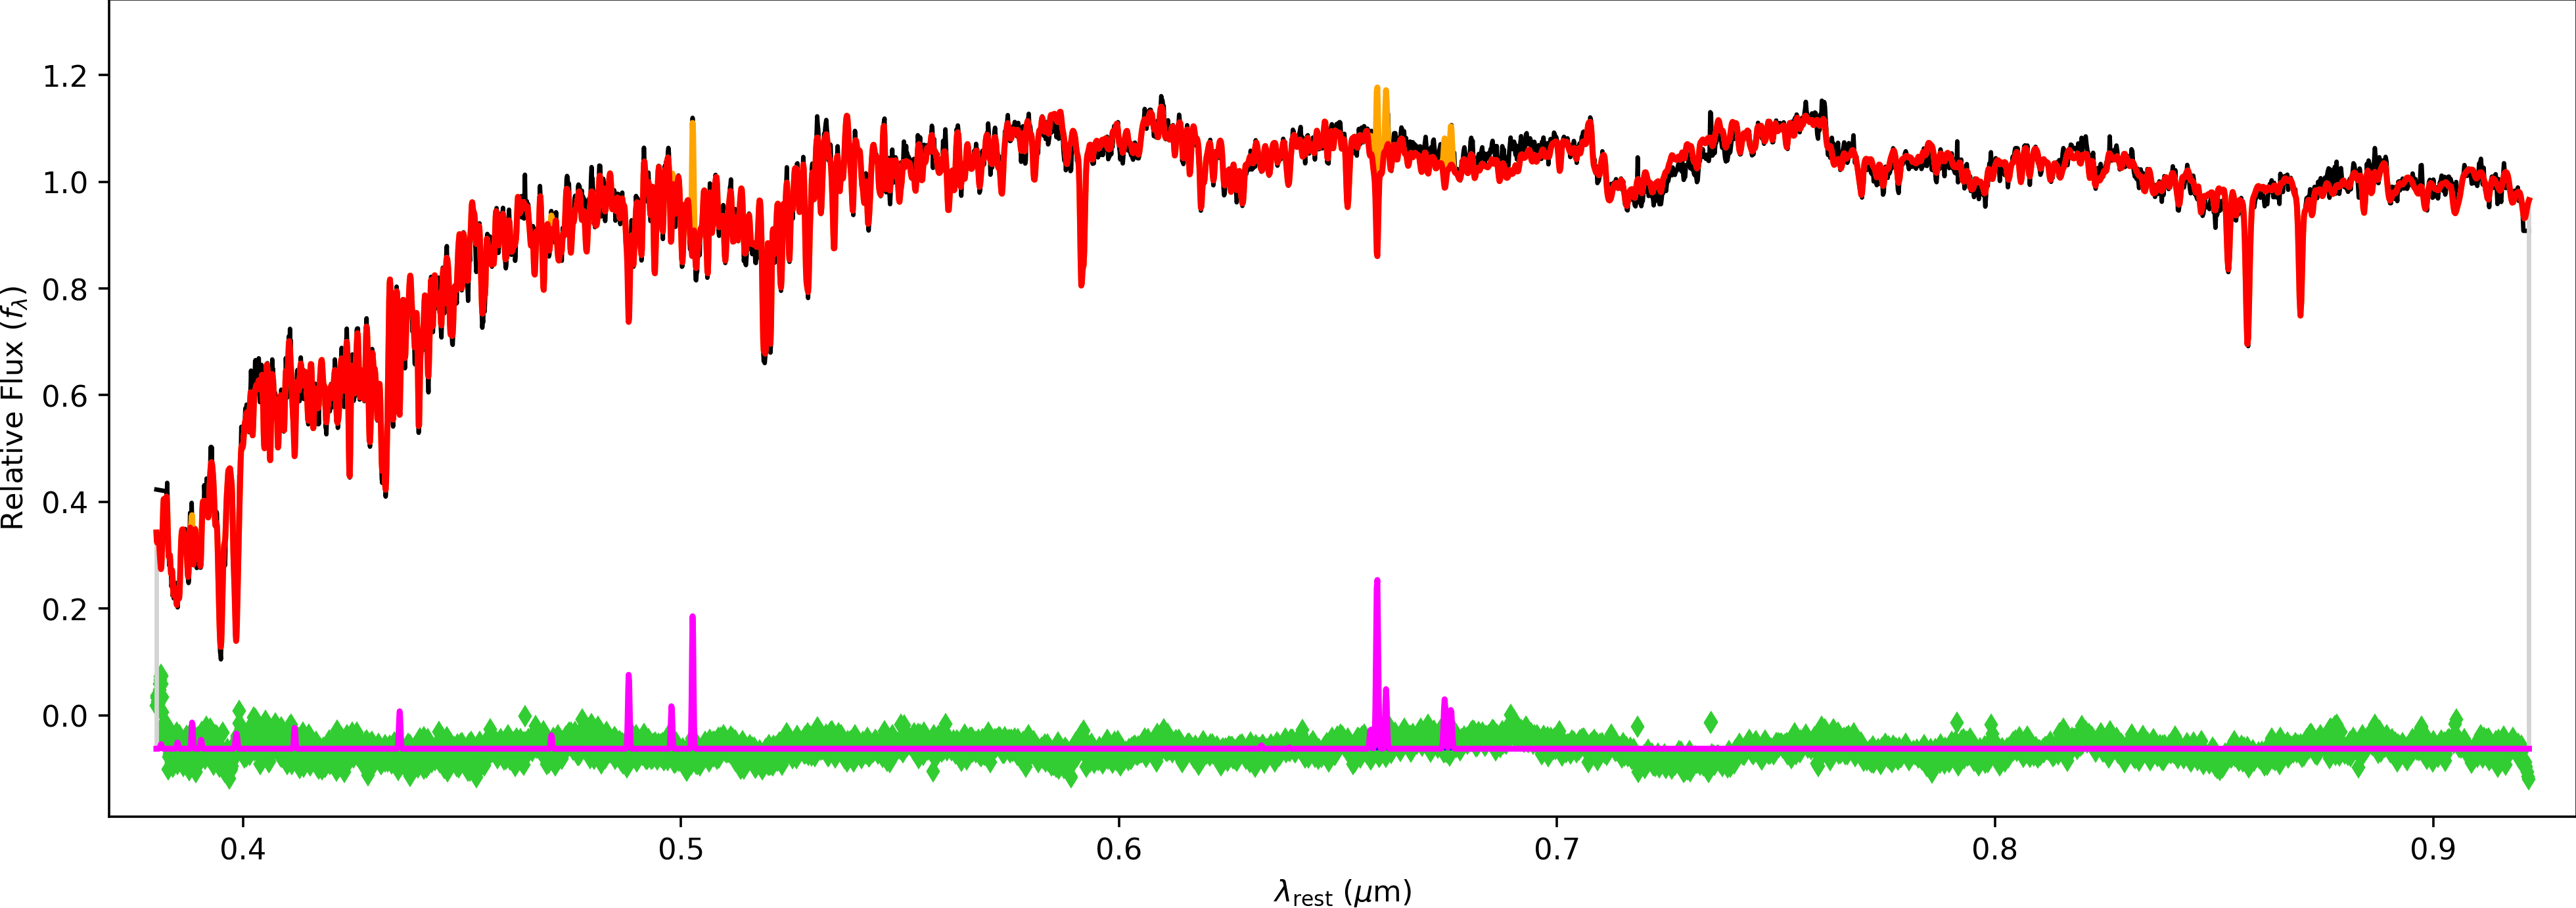

In [22]:
plt.figure(figsize=(15,5))
pp.plot()

## Plot stellar population for first regularized fit

In [23]:
weights = pp.weights[~gas_component]                # Exclude weights of the gas templates
weights = weights.reshape(reg_dim)/weights.sum()    # Normalized

Compute the light-weighted stellar population parameters and the stellar M/L.

In [24]:
sps.mean_age_metal(weights)
sps.mass_to_light(weights, band="SDSS/r", redshift=redshift);

Weighted <lg_age> [yr]: 9.87
Weighted <[M/H]>: -0.0713
(M*/L)=4.278 (SDSS/r at z=0.0040)


Plot stellar population mass fraction distribution

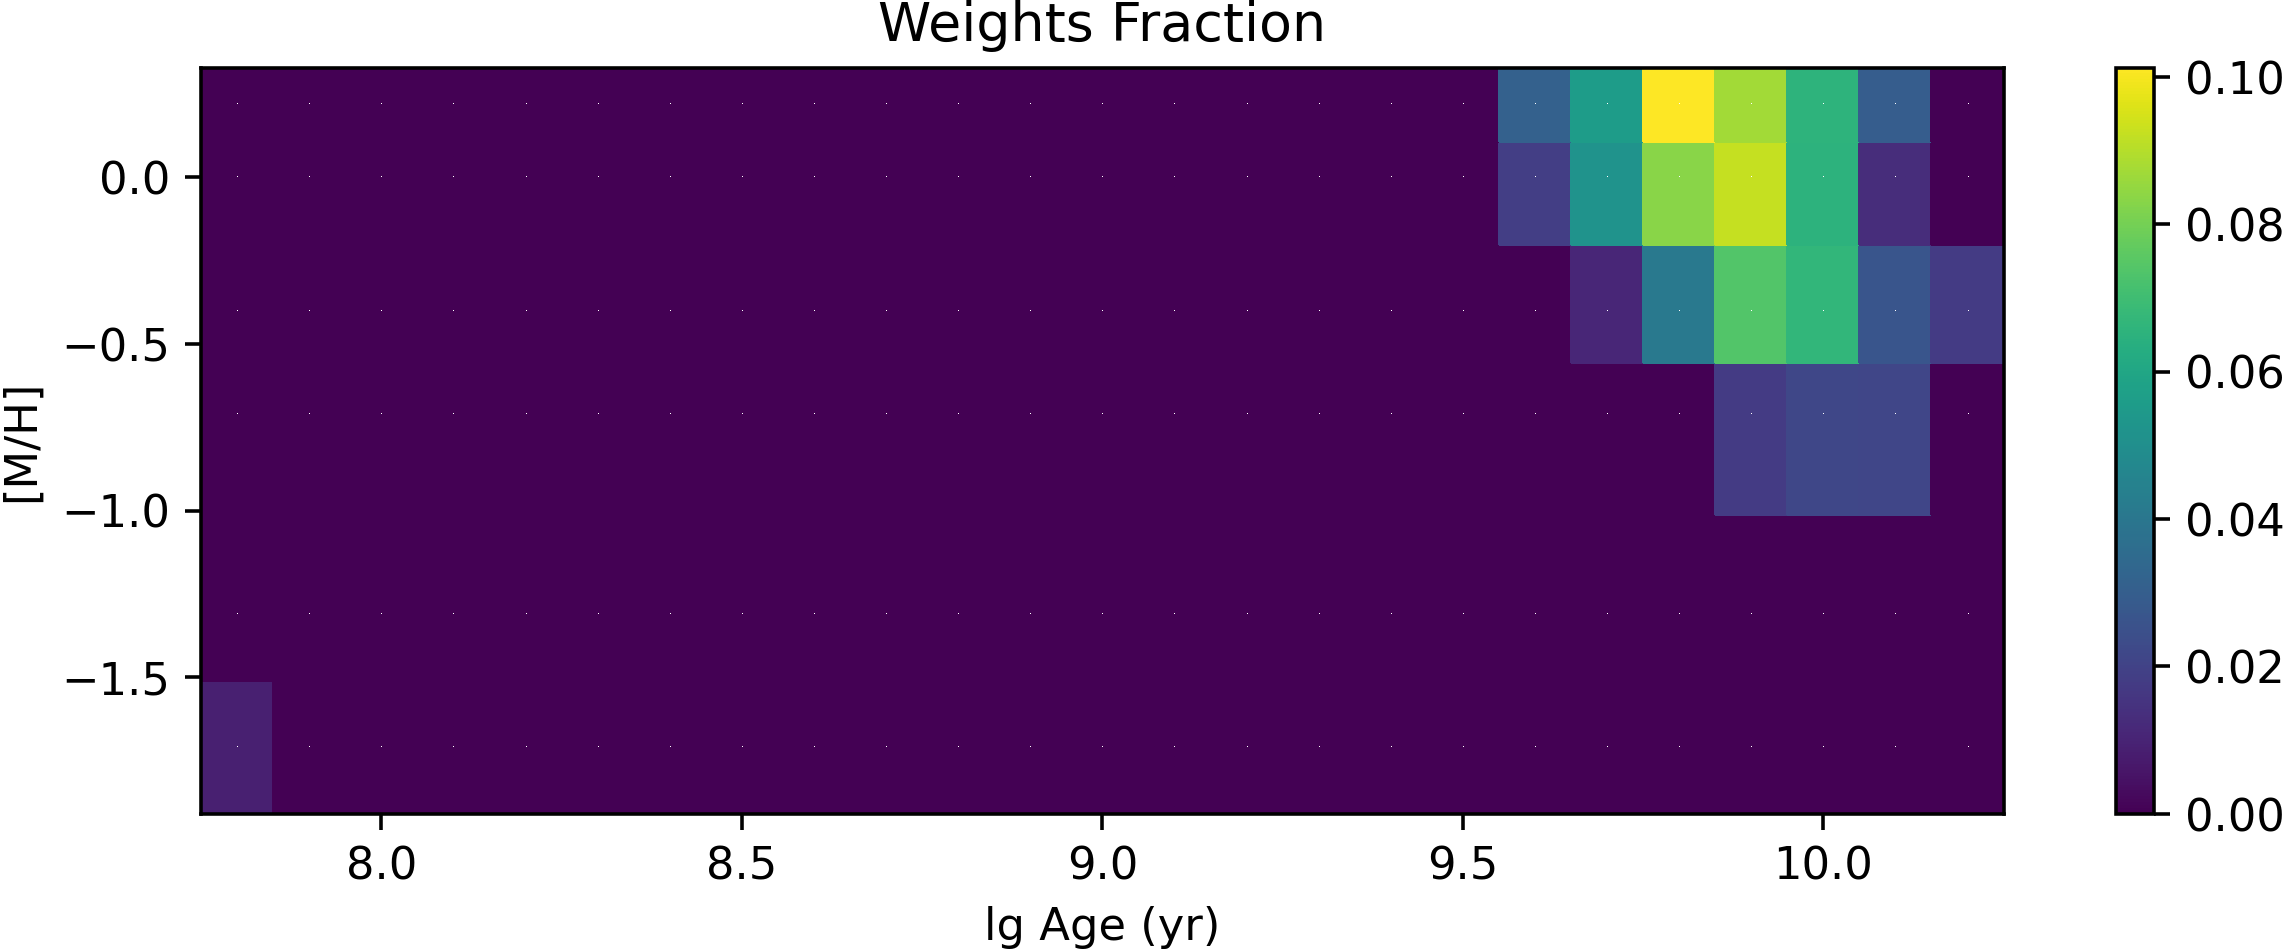

In [25]:
plt.figure(figsize=(9,3))
sps.plot(weights)

## Start bootstrapping

IMPORTANT: I store the residuals from the first fit. I will use them to bootstrap the spectrum by [reasampling residuals](https://en.wikipedia.org/wiki/Bootstrapping_(statistics)#Resampling_residuals)

In [26]:
bestfit0 = pp.bestfit.copy()
resid = galaxy - bestfit0
start = pp.sol.copy()

Here below I start the bootstrapping loop. All `pPXF` parameters are the same as before, with the exception that now I don't include regularization.

1/10: Elapsed time in pPXF: 2.47 s
2/10: Elapsed time in pPXF: 2.54 s
3/10: Elapsed time in pPXF: 2.76 s
4/10: Elapsed time in pPXF: 2.25 s
5/10: Elapsed time in pPXF: 1.91 s
6/10: Elapsed time in pPXF: 2.07 s
7/10: Elapsed time in pPXF: 1.92 s
8/10: Elapsed time in pPXF: 1.86 s
9/10: Elapsed time in pPXF: 2.58 s
10/10: Elapsed time in pPXF: 2.70 s


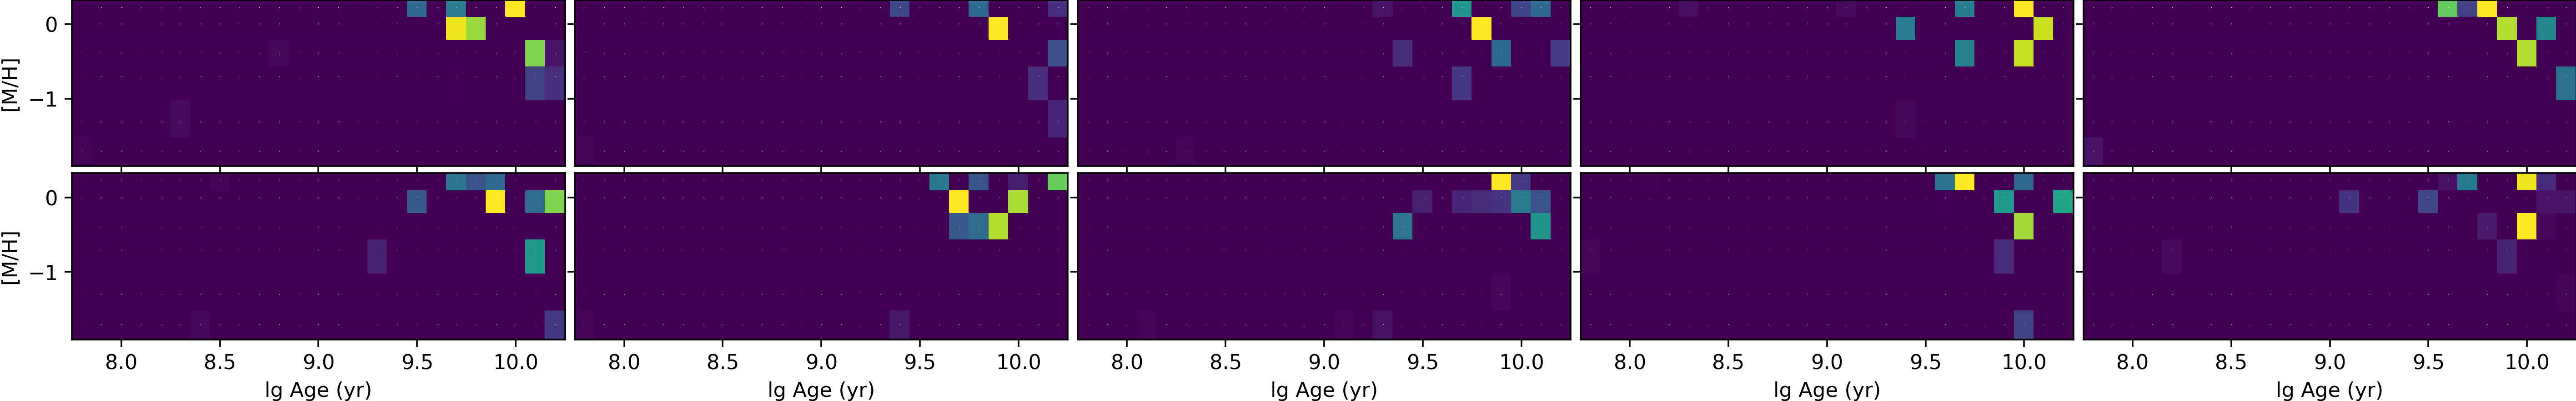

In [27]:
np.random.seed(123)

plt.subplots(2, 5, sharex=True, sharey=True, figsize=(22, 3))
plt.subplots_adjust(hspace=0.04)
plt.subplots_adjust(wspace=0.02)

nrand = 10
weights_array = np.empty((nrand, pp.weights.size))
for j in range(nrand):

    galaxy1 = bootstrap_residuals(bestfit0, resid)

    t = clock()
    pp = ppxf(templates, galaxy1, noise, velscale, start,
              moments=moments, degree=-1, mdegree=-1, lam=wave, lam_temp=sps.lam_temp,
              component=component, gas_component=gas_component, gas_names=gas_names,
              reddening=0, gas_reddening=0, quiet=1)
    print(f"{j + 1}/{nrand}: Elapsed time in pPXF: {clock() - t:.2f} s")

    weights_array[j] = pp.weights

    # Plot stellar population mass fraction distribution
    weights = pp.weights[~gas_component]                # Exclude weights of the gas templates
    weights = weights.reshape(reg_dim)/weights.sum()    # Normalized

    plt.subplot(2, 5, j + 1)
    ylabel="[M/H]" if j in [0, 5] else ""
    sps.plot(weights, colorbar=False, title="", ylabel=ylabel)

pp.weights = weights_array.sum(0)
weights_err = weights_array.std(0)

Plot the average stellar population mass fraction distribution and uncertainties.
See an example of application of this bootstrapping approach with pPXF in [Kacharov et al. (2018)](https://ui.adsabs.harvard.edu/abs/2018MNRAS.480.1973K)

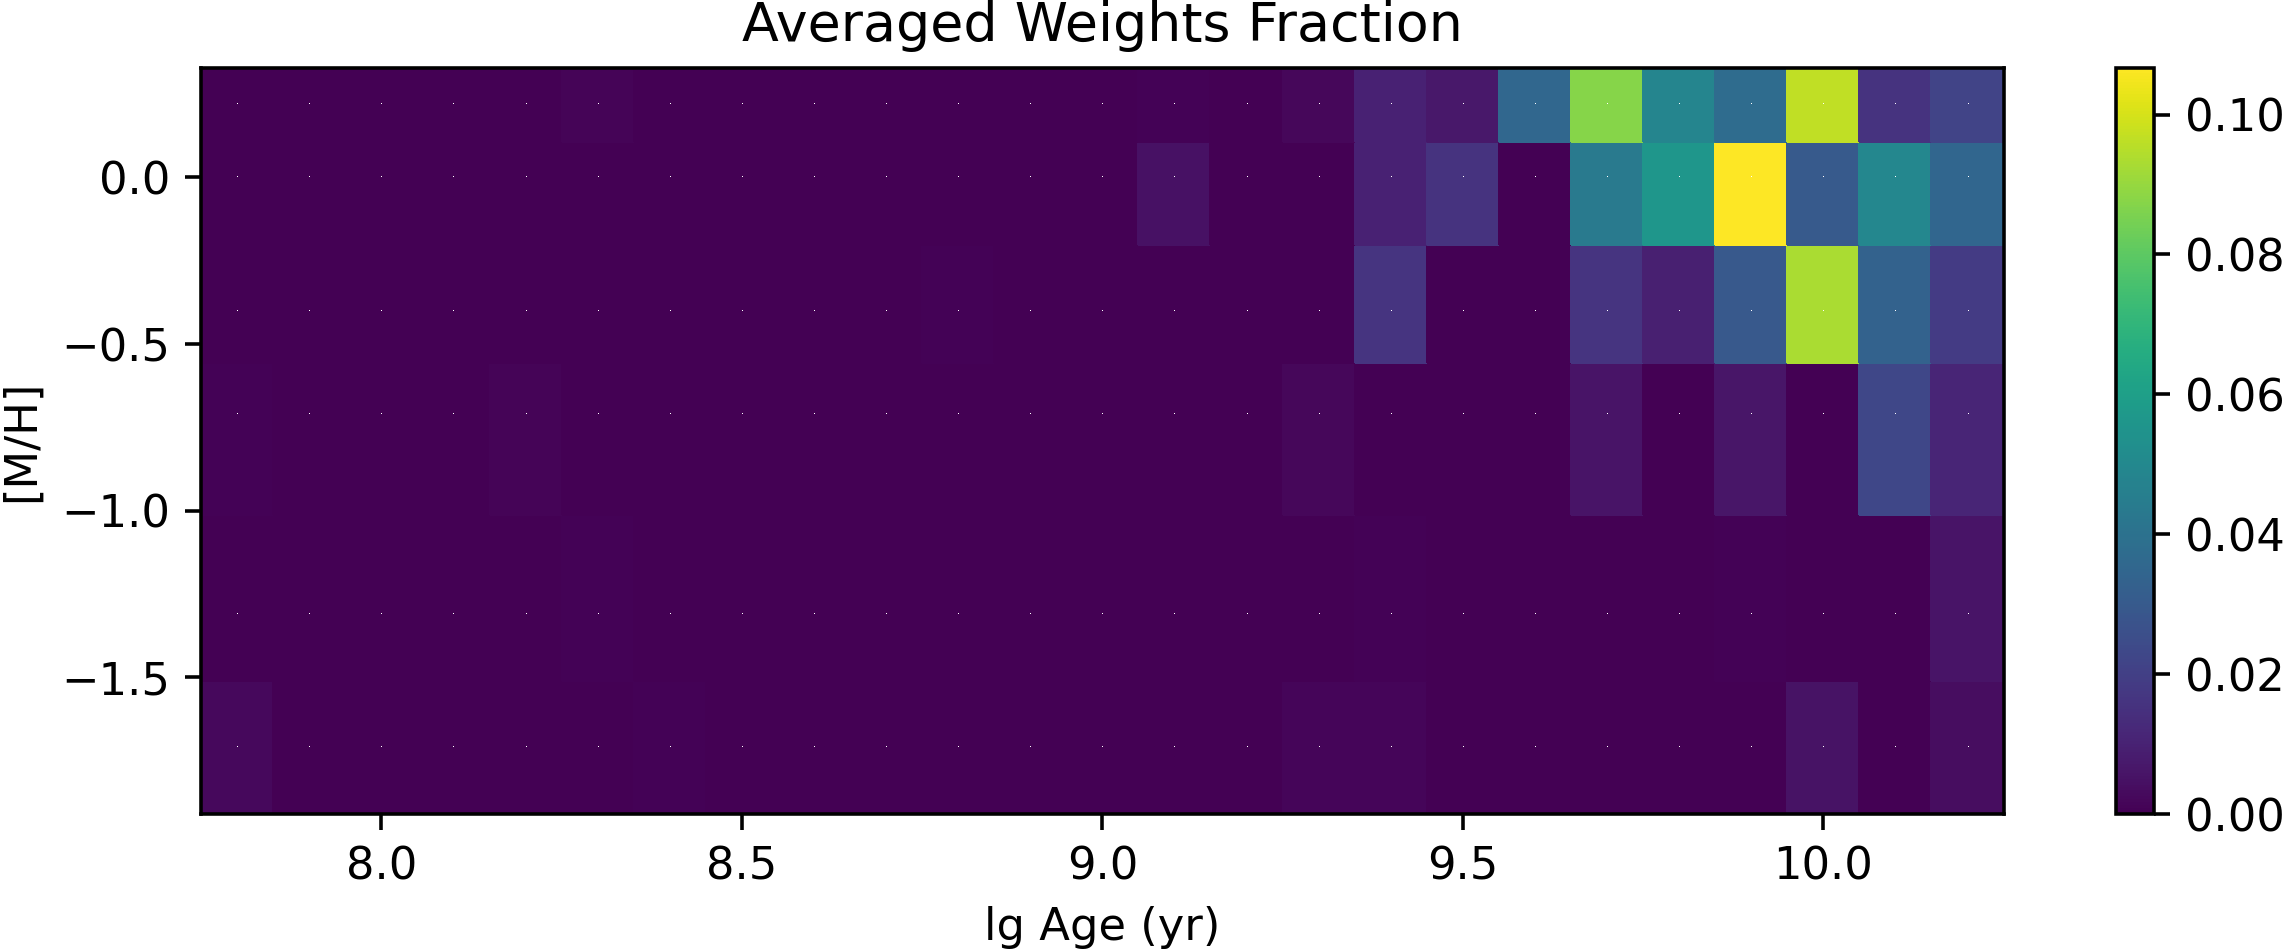

In [28]:
weights = pp.weights[~gas_component]  # Exclude weights of the gas templates
weights = weights.reshape(reg_dim)/weights.sum()  # Normalized

plt.figure(figsize=(9,3))
sps.plot(weights)
plt.title("Averaged Weights Fraction");

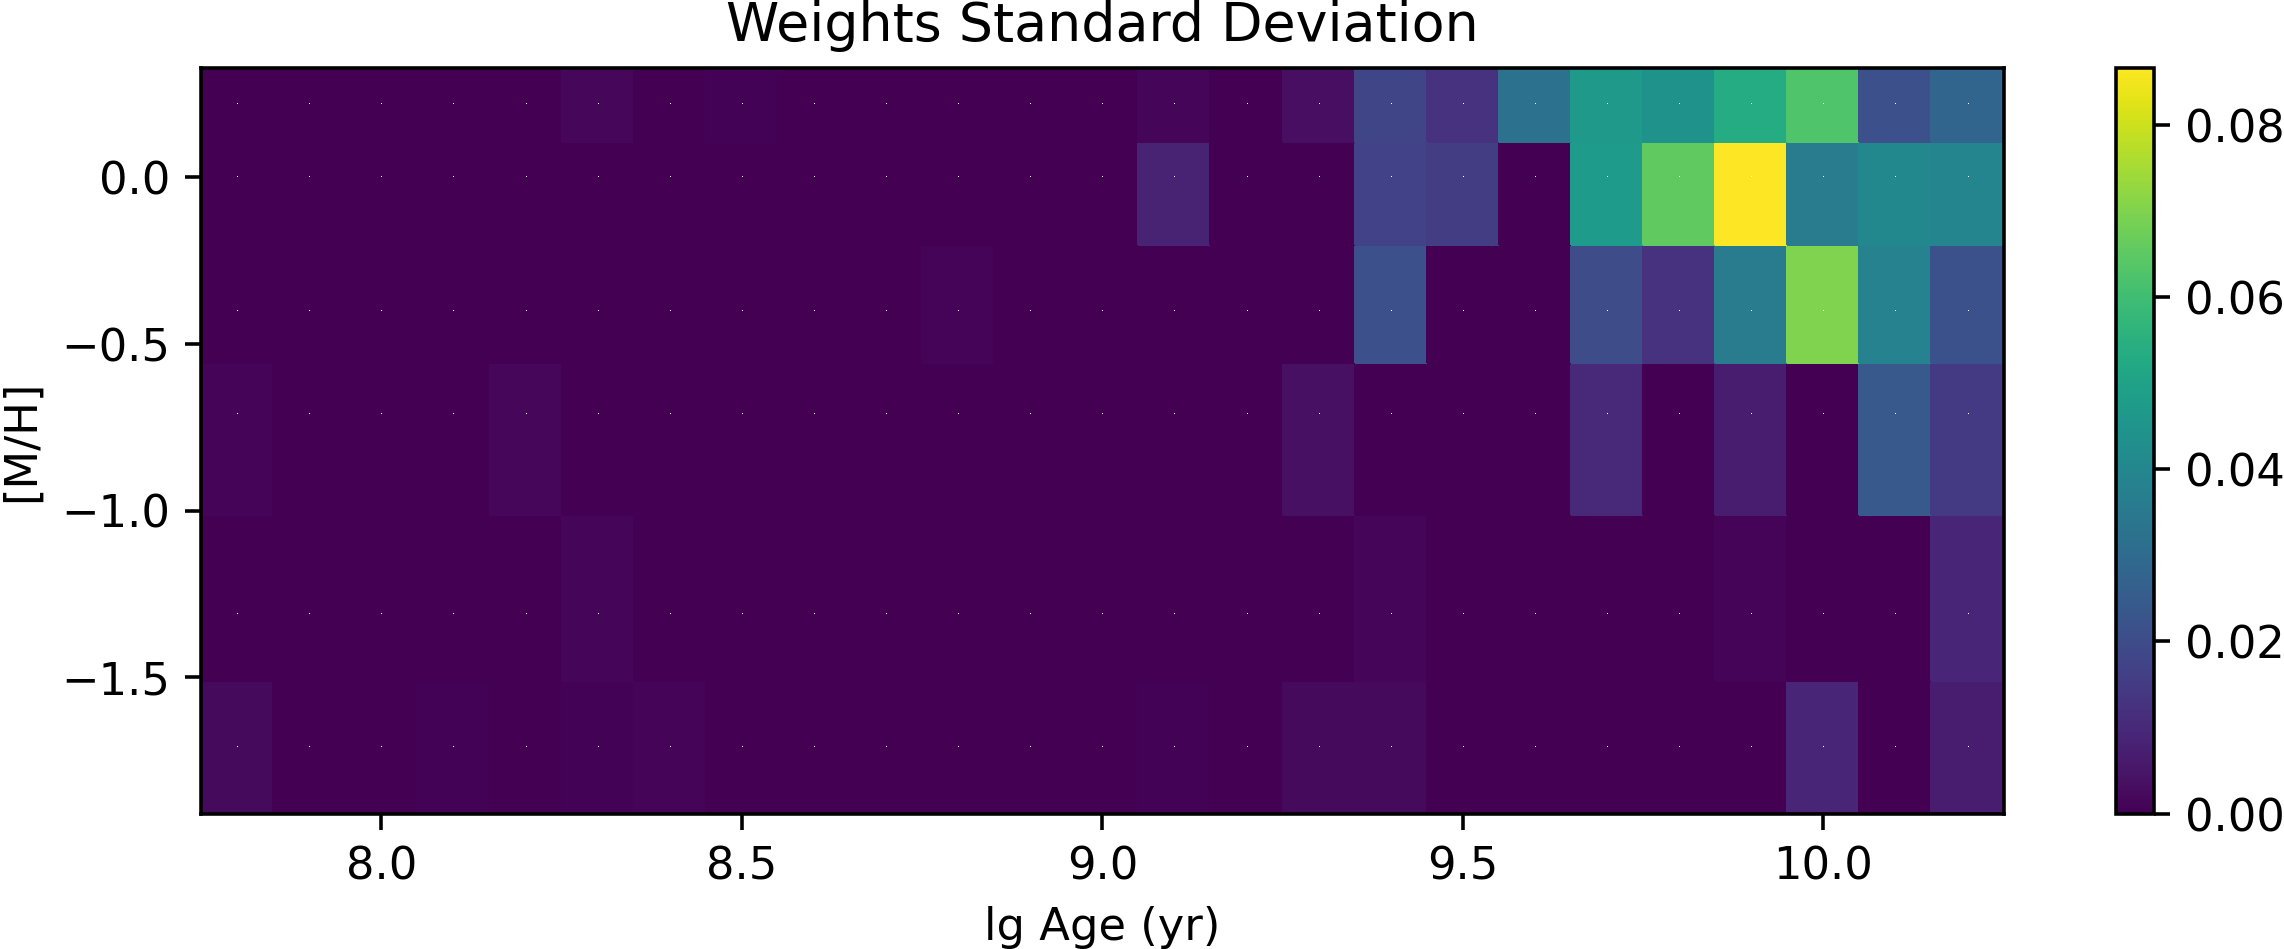

In [29]:
weights_err = weights_err[~gas_component]  # Exclude weights of the gas templates
weights_err = weights_err.reshape(reg_dim)/weights_err.sum()  # Normalized

plt.figure(figsize=(9,3))
sps.plot(weights_err)
plt.title("Weights Standard Deviation");